In [1]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow import gradients
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load the input data, their corresponding class labels, and the ROI mask
data = np.load("data/data.npy")
labels= np.load("data/labels.npy")
rois = np.load("data/maskROI.npy")

In [4]:
#Randomly split the data
index = np.random.RandomState(seed=1).permutation(9000)
all_data = data[index]
all_labels = labels[index]
train_data = all_data[0:8800]
train_labels= all_labels[0:8800][:,0]-1
val_data = all_data[8800:8900]
val_labels= all_labels[8800:8900][:,0]-1
test_data = all_data[8900:9000]
test_labels= all_labels[8900:9000][:,0]-1

In [5]:
#Get indices for inputs from each class
where_train_0 = np.where(train_labels==0)
where_train_1 = np.where(train_labels==1)
where_train_2 = np.where(train_labels==2)
where_val_0 = np.where(val_labels==0)
where_val_1 = np.where(val_labels==1)
where_val_2 = np.where(val_labels==2)
where_test_0 = np.where(test_labels==0)
where_test_1 = np.where(test_labels==1)
where_test_2 = np.where(test_labels==2)

In [6]:
#Load the template images for the three classes
temp_0 = np.load("data/classPrototype1.npy")
temp_1 = np.load("data/classPrototype2.npy")
temp_2 = np.load("data/classPrototype3.npy")
temp_avg = (temp_0+temp_1+temp_2)/3.0

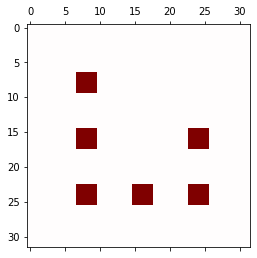

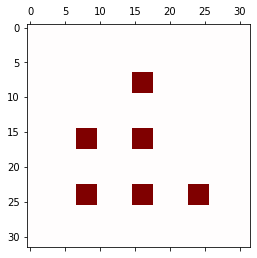

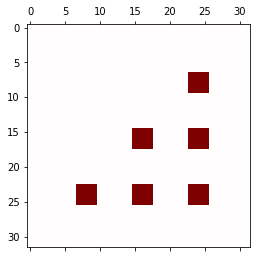

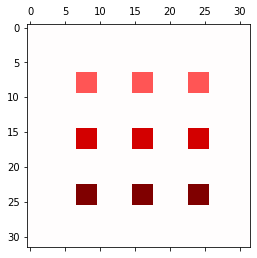

In [7]:
#Plot the three template images and the averge template image
clim = np.abs(temp_0).max()
plt.matshow(temp_0,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_1).max()
plt.matshow(temp_1,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_2).max()
plt.matshow(temp_2,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_avg).max()
plt.matshow(temp_avg,cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [8]:
#Get difference maps for the avg template with respect to the other templates
diff_0 = temp_0 - temp_avg
diff_1 = temp_1 - temp_avg
diff_2 = temp_2 - temp_avg

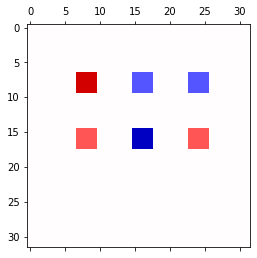

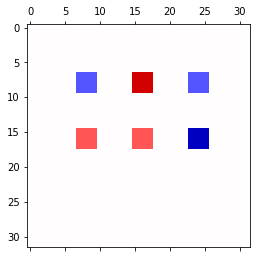

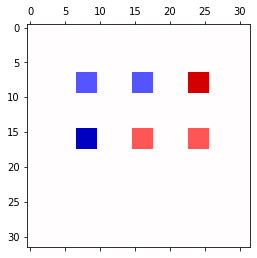

In [9]:
#Plot the difference maps for the avg template with respect to the other templates
plt.matshow(diff_0,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_1,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_2,cmap='seismic',vmin=-1.0,vmax=1)

In [10]:
#Declare Tensorflow input and output tensors

x = tf.placeholder(tf.float32, (None, 32,32), name = 'x')
        
y_true = tf.placeholder(tf.int64, (None), name='y')

x_flat = tf.contrib.layers.flatten(x)

mask_true = tf.one_hot(y_true,3)

In [11]:
#Declare linear model
with tf.variable_scope('l'):
    
    y_logits_l = tf.contrib.layers.fully_connected(x_flat,3,weights_regularizer=tf.keras.regularizers.l2(l=1e-5),activation_fn=None)

    y_logits_l = y_logits_l

    loss_l = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_l)

    probs_l = tf.nn.softmax(y_logits_l)

    acc_l = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_l, 1)),tf.float32))

    train_l = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_l)

    masked_loss_l = tf.reduce_sum( probs_l * mask_true,axis = -1)

    masked_logits_l = tf.reduce_sum(y_logits_l  * mask_true,axis = -1)

    w = tf.gradients(masked_logits_l,x)

    g_l = tf.gradients(masked_loss_l,x)

In [12]:
#Declare neural network model
with tf.variable_scope('nn'):
    h_nn = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = tf.contrib.layers.fully_connected(h_nn,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = y_logits_nn

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    probs_nn = tf.nn.softmax(y_logits_nn)

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    acc_nn = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_nn, 1)),tf.float32))

    train_nn = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_nn)

    masked_loss_nn = tf.reduce_sum( probs_nn * mask_true,axis = -1)

    masked_logits_nn = tf.reduce_sum( y_logits_nn * mask_true,axis = -1)

    g_nn = tf.gradients(masked_loss_nn,x)

In [13]:
#Declare neural network with random spherical noise model
with tf.variable_scope('sph'):
    h_sph = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = tf.contrib.layers.fully_connected(h_sph,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = y_logits_sph

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    probs_sph = tf.nn.softmax(y_logits_sph)

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    acc_sph = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_sph, 1)),tf.float32))

    train_sph = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_sph)

    masked_loss_sph = tf.reduce_sum( probs_sph * mask_true,axis = -1)

    masked_logits_sph = tf.reduce_sum( y_logits_sph * mask_true,axis = -1)

    g_sph = tf.gradients(masked_loss_sph,x)

In [14]:
#Declare neural network with advesarial training model 
with tf.variable_scope('adv'):
    
    h_adv = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_adv = tf.contrib.layers.fully_connected(h_adv,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    loss_adv = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_adv)

    probs_adv = tf.nn.softmax(y_logits_adv)

    acc_adv = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_adv, 1)),tf.float32))

    train_adv = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_adv)

    masked_loss_adv = tf.reduce_sum( probs_adv * mask_true,axis = -1)

    masked_logits_adv = tf.reduce_sum(y_logits_adv * mask_true,axis = -1)

    g_adv = tf.gradients(masked_loss_adv,x)

In [15]:
#Declare model savers
vars_l = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='l')
saver_l = tf.train.Saver(vars_l)
vars_nn = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='nn')
saver_nn = tf.train.Saver(vars_nn)
vars_sph = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='sph')
saver_sph = tf.train.Saver(vars_sph)
vars_adv = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='adv')
saver_adv = tf.train.Saver(vars_adv)

In [16]:
#Train linear model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_l, a_l = sess.run([train_l, loss_l, acc_l], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_l[0]))
        print('Acc L: ' + str(a_l))
    saver_l.save(sess, "saved_models/model_l.ckpt", write_meta_graph=False)

Loss L: 0.28683874
Acc L: 0.35306817
Loss L: 0.29233027
Acc L: 0.37170455
Loss L: 0.29812846
Acc L: 0.38840908
Loss L: 0.30347574
Acc L: 0.40329546
Loss L: 0.30806962
Acc L: 0.4230682
Loss L: 0.31160507
Acc L: 0.43988636
Loss L: 0.31390443
Acc L: 0.45772728
Loss L: 0.31489435
Acc L: 0.47806817
Loss L: 0.31456986
Acc L: 0.5055682
Loss L: 0.31298116
Acc L: 0.52602273
Loss L: 0.3102315
Acc L: 0.5468182
Loss L: 0.30645663
Acc L: 0.5709091
Loss L: 0.3018015
Acc L: 0.59647727
Loss L: 0.29640457
Acc L: 0.62113637
Loss L: 0.29039183
Acc L: 0.64375
Loss L: 0.2838703
Acc L: 0.6644318
Loss L: 0.2769328
Acc L: 0.68613636
Loss L: 0.2696705
Acc L: 0.7105682
Loss L: 0.2621764
Acc L: 0.7336364
Loss L: 0.25453886
Acc L: 0.7559091
Loss L: 0.24683425
Acc L: 0.7755682
Loss L: 0.23912144
Acc L: 0.79375
Loss L: 0.23144147
Acc L: 0.8122727
Loss L: 0.22382158
Acc L: 0.8319318
Loss L: 0.21627992
Acc L: 0.8493182
Loss L: 0.20883033
Acc L: 0.8660227
Loss L: 0.20148526
Acc L: 0.88011366
Loss L: 0.19425862
Acc L: 

In [17]:
#Get validation results for the linear model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))


INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.48208842
Acc L: 1.0


In [18]:
#Get test results for the linear model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.22388133
Acc L: 1.0


In [16]:
#Get weights and test data gradients for the linear model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    #Get weights and gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_l_0, weights_l_0 = sess.run([g_l,w], feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get weights and gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_l_1, weights_l_1 = sess.run([g_l,w], feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get weights and gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_l_2, weights_l_2 = sess.run([g_l,w], feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get weights and gradients for class 1 for class 0 inputs
    grad_l_0_1, weights_l_0_1 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 0 inputs
    grad_l_0_2, weights_l_0_2 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 1 inputs 
    grad_l_1_0, weights_l_1_0 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 1 inputs
    grad_l_1_2, weights_l_1_2 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 2 inputs
    grad_l_2_0, weights_l_2_0 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get weights and gradients for class 1 for class 2 inputs
    grad_l_2_1, weights_l_2_1 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt


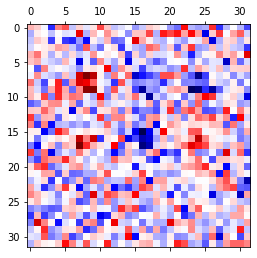

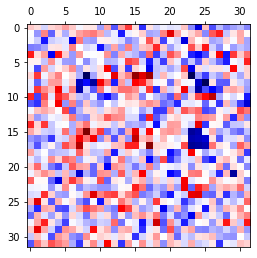

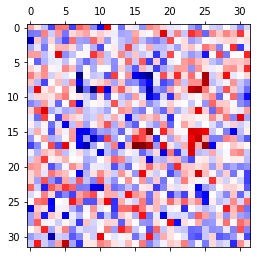

In [17]:
#Plot linear model weights for the three classes
#Plot weights for class 0
clim = np.abs(weights_l_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 1
clim = np.abs(weights_l_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 2
clim = np.abs(weights_l_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

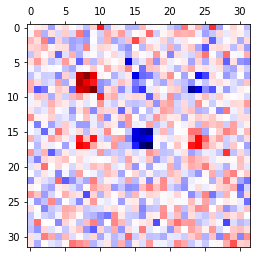

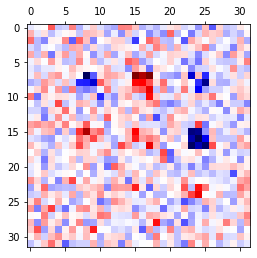

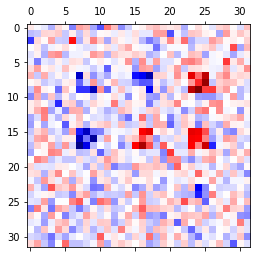

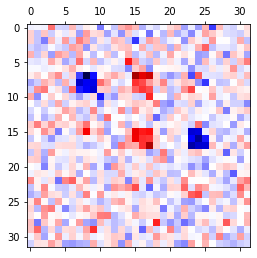

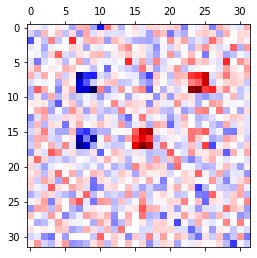

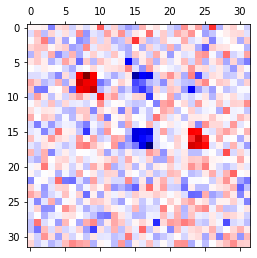

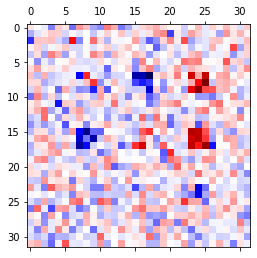

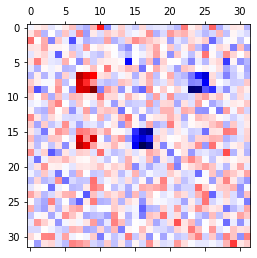

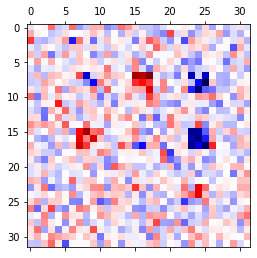

In [18]:
#Plot gradients for the linear model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_l_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_l_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_l_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_l_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_l_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_l_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_l_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_l_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_l_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [19]:
#Train neural network model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_nn, a_nn = sess.run([train_nn, loss_nn, acc_nn], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_nn[0]))
        print('Acc L: ' + str(a_nn))
    saver_nn.save(sess, "saved_models/model_nn.ckpt", write_meta_graph=False)

Loss L: 0.91789544
Acc L: 0.43602273
Loss L: 0.91821706
Acc L: 0.48090908
Loss L: 0.9180453
Acc L: 0.53022724
Loss L: 0.9161223
Acc L: 0.5821591
Loss L: 0.911744
Acc L: 0.6339773
Loss L: 0.9062969
Acc L: 0.67965907
Loss L: 0.9016458
Acc L: 0.7277273
Loss L: 0.89381796
Acc L: 0.7764773
Loss L: 0.87366533
Acc L: 0.81511366
Loss L: 0.83756495
Acc L: 0.84670454
Loss L: 0.80021775
Acc L: 0.8756818
Loss L: 0.76208115
Acc L: 0.9
Loss L: 0.7187234
Acc L: 0.9195455
Loss L: 0.67198324
Acc L: 0.9359091
Loss L: 0.6124036
Acc L: 0.9523864
Loss L: 0.5555702
Acc L: 0.9644318
Loss L: 0.5022292
Acc L: 0.9718182
Loss L: 0.45123214
Acc L: 0.9785227
Loss L: 0.39142412
Acc L: 0.98477274
Loss L: 0.340902
Acc L: 0.9876136
Loss L: 0.29645193
Acc L: 0.9917045
Loss L: 0.25751323
Acc L: 0.9940909
Loss L: 0.2235707
Acc L: 0.9959091
Loss L: 0.19298404
Acc L: 0.9969318
Loss L: 0.16160254
Acc L: 0.99806815
Loss L: 0.1341255
Acc L: 0.99863636
Loss L: 0.11152242
Acc L: 0.9994318
Loss L: 0.09301007
Acc L: 0.99954545
Lo

In [20]:
#Get validation results for the neural network model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.16747588
Acc L: 1.0


In [21]:
#Get test results for the neural network model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.01399501
Acc L: 1.0


In [22]:
#Get test data gradients for the neural network model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_nn_0 = sess.run(g_nn, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_nn_1 = sess.run(g_nn, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_nn_2 = sess.run(g_nn, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_nn_0_1 = sess.run(g_nn, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_nn_0_2 = sess.run(g_nn, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_nn_1_0 = sess.run(g_nn, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_nn_1_2 = sess.run(g_nn, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_nn_2_0 = sess.run(g_nn, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_nn_2_1 = sess.run(g_nn, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


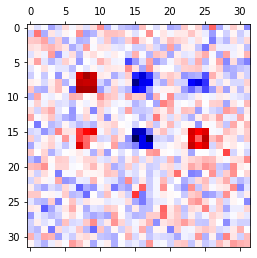

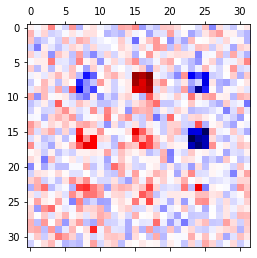

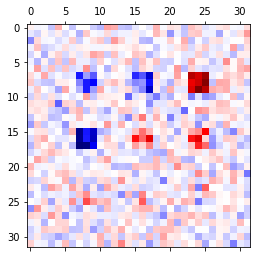

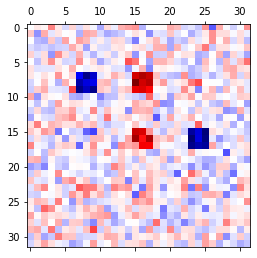

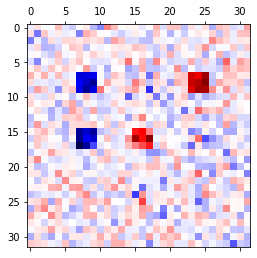

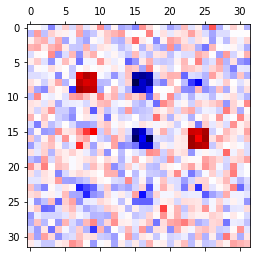

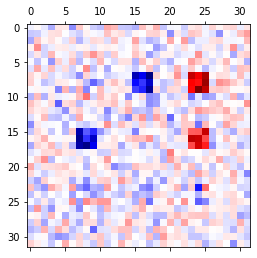

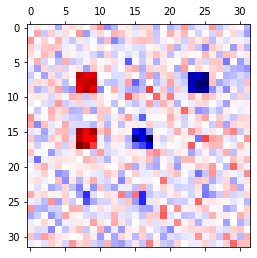

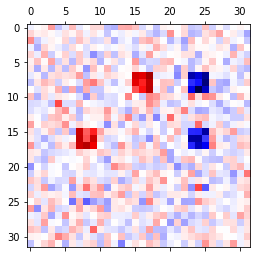

In [23]:
#Plot gradients for the neural network model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_nn_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_nn_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_nn_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_nn_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_nn_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_nn_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_nn_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_nn_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_nn_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [24]:
#Get test data gradients for the neural network model with SmoothGrad

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: test_labels[where_test_0[0]]})[0])
    grad_sg_0 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: test_labels[where_test_1[0]]})[0])
    grad_sg_1 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: test_labels[where_test_2[0]]})[0])
    grad_sg_2 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_1 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 2 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_2 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 0 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 2 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_2 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 0 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 1 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_1 = np.array(grads).mean(axis=0,keepdims=True)

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


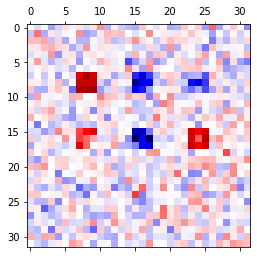

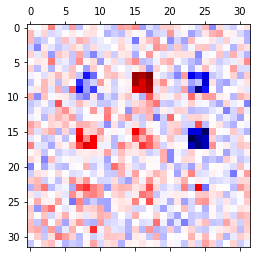

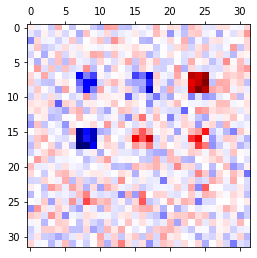

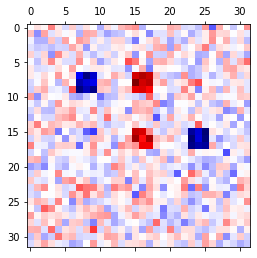

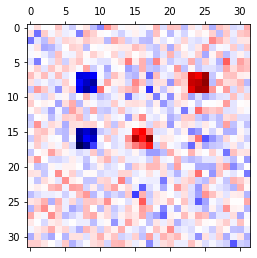

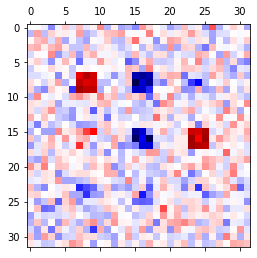

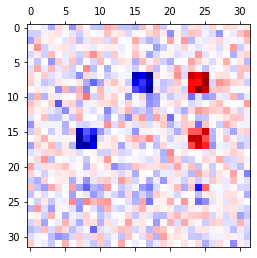

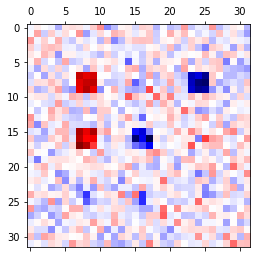

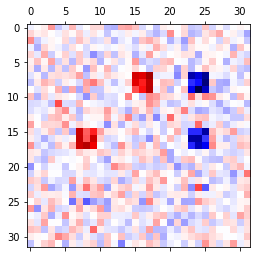

In [25]:
#Plot gradients for the neural network model with SmoothGrad

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sg_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sg_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sg_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sg_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sg_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sg_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sg_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sg_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sg_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [26]:
#Define function to generate uniform spherical noise
def get_sph_noise(shape,epsilon):
    n_noise_samples = shape[0]
    shape.pop(0)
    noise = []
    for n in range(n_noise_samples):
        noise_tmp = np.random.normal(size=shape)
        u = np.random.uniform(size=())
        noise_tmp = (epsilon*(u**(1.0/float(np.prod(np.array(shape))))) * noise_tmp / (np.linalg.norm(noise_tmp)+1e-16))  
        noise.append(noise_tmp)
    return np.array(noise)

In [27]:
#Train neural network model with random spherical noise
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        noise = get_sph_noise(list(train_data.shape),1.0)
        _, l_sph, a_sph = sess.run([train_sph, loss_sph, acc_sph], feed_dict={x: train_data+noise, y_true: train_labels})
        print('Loss L: ' + str(l_sph[0]))
        print('Acc L: ' + str(a_sph))
    saver_sph.save(sess, "saved_models/model_sph.ckpt", write_meta_graph=False)

Loss L: 2.4610715
Acc L: 0.28806818
Loss L: 2.1561537
Acc L: 0.30727273
Loss L: 1.9625825
Acc L: 0.33454546
Loss L: 1.6160988
Acc L: 0.36397728
Loss L: 1.5773058
Acc L: 0.40693182
Loss L: 1.3651226
Acc L: 0.4515909
Loss L: 1.1929991
Acc L: 0.50511366
Loss L: 1.1206042
Acc L: 0.5544318
Loss L: 0.9935545
Acc L: 0.6026136
Loss L: 0.86584675
Acc L: 0.65090907
Loss L: 0.7712937
Acc L: 0.69102275
Loss L: 0.7197266
Acc L: 0.7367045
Loss L: 0.6832738
Acc L: 0.7731818
Loss L: 0.6250668
Acc L: 0.8078409
Loss L: 0.5999571
Acc L: 0.8353409
Loss L: 0.5434423
Acc L: 0.8603409
Loss L: 0.52531636
Acc L: 0.88284093
Loss L: 0.508674
Acc L: 0.9031818


KeyboardInterrupt: 

In [28]:
#Get validation results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.123603396
Acc L: 1.0


In [29]:
#Get test results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.02130772
Acc L: 1.0


In [43]:
#Get test data gradients for the neural network model trained with spherical noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_sph_0 = sess.run(g_sph, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_sph_1 = sess.run(g_sph, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_sph_2 = sess.run(g_sph, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_sph_0_1 = sess.run(g_sph, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_sph_0_2 = sess.run(g_sph, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_sph_1_0 = sess.run(g_sph, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_sph_1_2 = sess.run(g_sph, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_sph_2_0 = sess.run(g_sph, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_sph_2_1 = sess.run(g_sph, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt


In [30]:
#Plot gradients for the neural network model trained with spherical noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sph_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sph_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sph_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sph_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sph_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sph_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sph_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sph_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sph_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

NameError: name 'grad_sph_0' is not defined

In [45]:
#Train neural network model with adversarial noise
n_ep = 50
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_adv, a_adv, grads_adv = sess.run([train_adv, loss_adv, acc_adv, g_adv], feed_dict={x: train_data, y_true: train_labels})
        del_1 = grads_adv[0]
        norm_del_1 = np.linalg.norm(del_1,axis=(1,2))
        norm_where = np.where(norm_del_1>0.0)
        norm_del_1 = np.reshape(norm_del_1,(-1,1,1))
        del_1[norm_where] = del_1[norm_where] / norm_del_1[norm_where]
        del_1 *= -0.1
        del_2 = sess.run(g_adv, feed_dict={x: train_data + del_1, y_true: train_labels})[0]
        norm_del_2 = np.linalg.norm(del_2,axis=(1,2))
        norm_where = np.where(norm_del_2>0.0)
        norm_del_2 = np.reshape(norm_del_2,(-1,1,1))
        del_2[norm_where] = del_2[norm_where] / norm_del_2[norm_where]
        del_2 = del_1 - 1.0 * del_2
        del_3 = sess.run(g_adv, feed_dict={x: train_data + del_2, y_true: train_labels})[0]
        norm_del_3 = np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>0.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        del_3[norm_where] = del_3[norm_where] / norm_del_3[norm_where]
        del_3 = del_2 - 0.1 * del_3
        norm_del_3 =  np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>1.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        if len(norm_where) > 0:
            del_3[norm_where] = 1.0 * del_3[norm_where] / norm_del_3[norm_where] 
        _ = sess.run(train_adv, feed_dict={x: (train_data + del_3), y_true: train_labels})
        print('Loss L: ' + str(l_adv[0]))
        print('Acc L: ' + str(a_adv))
    saver_adv.save(sess, "saved_models/model_adv.ckpt", write_meta_graph=False)

Loss L: 0.5139222
Acc L: 0.38352272
Loss L: 0.49762505
Acc L: 0.4715909
Loss L: 0.4767861
Acc L: 0.56113636
Loss L: 0.4866257
Acc L: 0.65261364
Loss L: 0.49412102
Acc L: 0.73397726
Loss L: 0.48981398
Acc L: 0.80545455
Loss L: 0.46565396
Acc L: 0.8703409
Loss L: 0.42405322
Acc L: 0.91738635
Loss L: 0.36837852
Acc L: 0.9507955
Loss L: 0.31229556
Acc L: 0.9709091
Loss L: 0.25975326
Acc L: 0.98477274
Loss L: 0.21290107
Acc L: 0.9934091
Loss L: 0.17450017
Acc L: 0.9967045
Loss L: 0.14009596
Acc L: 0.9984091
Loss L: 0.10998162
Acc L: 0.9997727
Loss L: 0.085891694
Acc L: 1.0
Loss L: 0.066908285
Acc L: 1.0
Loss L: 0.052249033
Acc L: 1.0
Loss L: 0.0406813
Acc L: 1.0
Loss L: 0.031592637
Acc L: 1.0
Loss L: 0.024527427
Acc L: 1.0
Loss L: 0.019367166
Acc L: 1.0
Loss L: 0.015524258
Acc L: 1.0
Loss L: 0.012719457
Acc L: 1.0
Loss L: 0.010486501
Acc L: 1.0
Loss L: 0.0087272655
Acc L: 1.0
Loss L: 0.007351253
Acc L: 1.0
Loss L: 0.0062804474
Acc L: 1.0
Loss L: 0.0054450533
Acc L: 1.0
Loss L: 0.004786462
A

In [31]:
#Get validation results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.03669863
Acc L: 1.0


In [32]:
#Get test results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.020574132
Acc L: 1.0


In [33]:
#Get test data gradients for the neural network model trained with adversarial noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_adv_0 = sess.run(g_adv, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_adv_1 = sess.run(g_adv, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_adv_2 = sess.run(g_adv, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_adv_0_1 = sess.run(g_adv, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_adv_0_2 = sess.run(g_adv, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_adv_1_0 = sess.run(g_adv, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_adv_1_2 = sess.run(g_adv, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_adv_2_0 = sess.run(g_adv, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_adv_2_1 = sess.run(g_adv, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt


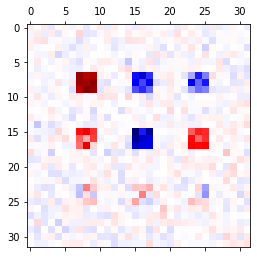

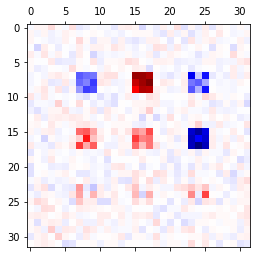

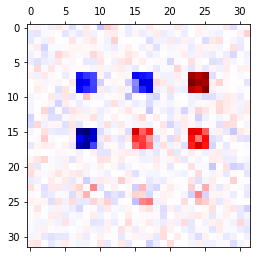

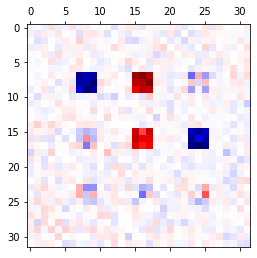

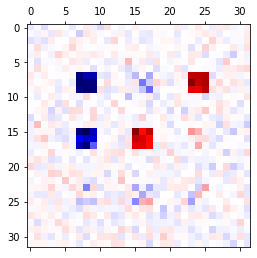

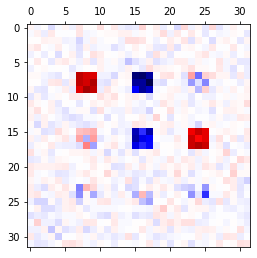

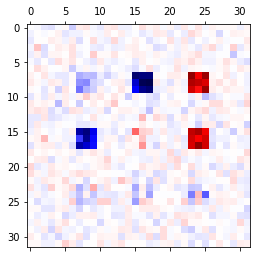

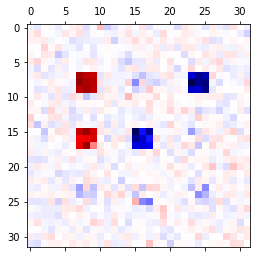

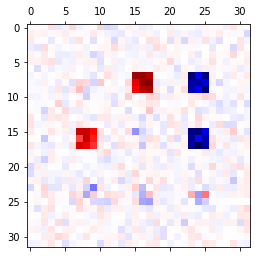

In [34]:
#Plot gradients for the neural network model trained with adversarial noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_adv_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_adv_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_adv_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_adv_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_adv_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_adv_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_adv_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_adv_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_adv_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [44]:
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

In [45]:
#Correlation between the class 0 template minus the average template and the class 0 weights
pearsonr(np.reshape(weights_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.4384282886924128, 2.4010001226022086e-49)

In [46]:
#Correlation between the class 0 template minus the average template and the average class 0 linear model gradient for class 0 inputs
pearsonr(np.reshape(grad_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.6082362882542584, 1.2372656175840904e-104)

In [47]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network gradient for class 0 inputs
pearsonr(np.reshape(grad_nn_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.714176931598381, 1.6256985729252495e-160)

In [48]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network trained with spherical noise gradient for class 0 inputs
pearsonr(np.reshape(grad_sph_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.6804235266935702, 3.895328373801468e-140)

In [49]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network SmoothGrad gradient for class 0 inputs
pearsonr(np.reshape(grad_sg_0.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7118710444802903, 4.976318666199099e-159)

In [50]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network with adversarial training gradient for class 0 inputs
pearsonr(np.reshape(grad_adv_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.9306328419620203, 0.0)

In [51]:
#Correlation between the class 1 template minus the average template and the class 1 weights
pearsonr(np.reshape(weights_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.41240289064402963, 2.5602717658520584e-43)

In [52]:
#Correlation between the class 1 template minus the average template and the average class 1 linear model gradient for class 1 inputs
pearsonr(np.reshape(grad_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.5720613264309488, 4.684567997860931e-90)

In [53]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network gradient for class 1 inputs
pearsonr(np.reshape(grad_nn_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7111543116610757, 1.4314271862659334e-158)

In [54]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network trained with spherical noise gradient for class 1 inputs
pearsonr(np.reshape(grad_sph_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7052579391183167, 7.550661898866675e-155)

In [55]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network SmoothGrad gradient for class 1 inputs
pearsonr(np.reshape(grad_sg_1.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7157044716596981, 1.6541135557338989e-161)

In [56]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network with adversarial training gradient for class 1 inputs
pearsonr(np.reshape(grad_adv_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.9228565115603691, 0.0)

In [57]:
#Correlation between the class 2 template minus the average template and the class 2 weights
pearsonr(np.reshape(weights_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.41013627194609587, 8.102811811138237e-43)

In [58]:
#Correlation between the class 2 template minus the average template and the average class 2 linear model gradient for class 2 inputs
pearsonr(np.reshape(grad_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.5756364836235778, 2.043040640805722e-91)

In [59]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network gradient for class 2 inputs
pearsonr(np.reshape(grad_nn_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.7422643001958169, 7.009509560959569e-180)

In [60]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network trained with spherical noise gradient for class 2 inputs
pearsonr(np.reshape(grad_sph_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.6980181577938744, 2.1063538026782098e-150)

In [61]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network SmoothGrad gradient for class 2 inputs
pearsonr(np.reshape(grad_sg_2.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.740472862835291, 1.4309255548009363e-178)

In [62]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network with adversarial training gradient for class 2 inputs
pearsonr(np.reshape(grad_adv_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.9323149887598365, 0.0)

In [63]:
#Get the correlation between the class template minus the average template and the respective weights for each input
corrs_weights = []
for i in range(weights_l_0[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(weights_l_1[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(weights_l_2[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [64]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_l = []
for i in range(grad_l_0[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_l_1[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_l_2[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [65]:
#Get the correlation between the class template minus the average template and the respective neural network gradient for each input
corrs_grad_nn = []
for i in range(grad_nn_0[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_nn_1[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_nn_2[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [66]:
#Get the correlation between the class template minus the average template and the respective neural network trained with spherical noise gradient for each input
corrs_grad_sph = []
for i in range(grad_sph_0[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sph_1[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sph_2[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [67]:
#Get the correlation between the class template minus the average template and the respective neural network SmoothGrad gradient for each input
corrs_grad_sg = []
for i in range(grad_sg_0[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sg_1[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sg_2[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [68]:
#Get the correlation between the class template minus the average template and the respective neural network with adversarial training gradient for each input
corrs_grad_adv = []
for i in range(grad_adv_0[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_adv_1[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_adv_2[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [69]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights,corrs_grad_l)

Ttest_relResult(statistic=-109.9709315911095, pvalue=2.6725430857079828e-105)

In [70]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights,corrs_grad_nn)

Ttest_relResult(statistic=-38.8413316768796, pvalue=9.863270921695858e-62)

In [71]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights,corrs_grad_sph)

Ttest_relResult(statistic=-31.288118568644073, pvalue=3.9254932508706375e-53)

In [72]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network SmoothGrad gradients
ttest_rel(corrs_weights,corrs_grad_sg)

Ttest_relResult(statistic=-51.58860327534399, pvalue=2.3267453583975627e-73)

In [73]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network with adversarial training gradients
ttest_rel(corrs_weights,corrs_grad_adv)

Ttest_relResult(statistic=-60.42889091387812, pvalue=5.948144622572506e-80)

In [74]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l,corrs_grad_nn)

Ttest_relResult(statistic=-11.431857361107351, pvalue=8.510076145171216e-20)

In [75]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_l,corrs_grad_sph)

Ttest_relResult(statistic=-6.592750050357675, pvalue=2.1232056260057826e-09)

In [76]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l,corrs_grad_sg)

Ttest_relResult(statistic=-17.555899705840528, pvalue=3.6315418701946375e-32)

In [77]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l,corrs_grad_adv)

Ttest_relResult(statistic=-38.923845196425376, pvalue=8.097148355444616e-62)

In [78]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn,corrs_grad_sph)

Ttest_relResult(statistic=2.998268875006344, pvalue=0.0034333230190020025)

In [79]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn,corrs_grad_sg)

Ttest_relResult(statistic=-6.071992543186871, pvalue=2.3434006323526023e-08)

In [80]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn,corrs_grad_adv)

Ttest_relResult(statistic=-25.574331087414837, pvalue=2.0618151897895153e-45)

In [81]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network trained with spherical gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sph,corrs_grad_sg)

Ttest_relResult(statistic=-5.834305947487824, pvalue=6.827494218577981e-08)

In [82]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network trained with spherical gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph,corrs_grad_adv)

Ttest_relResult(statistic=-26.99077884031141, pvalue=1.925230998897133e-47)

In [83]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg,corrs_grad_adv)

Ttest_relResult(statistic=-26.63223116005444, pvalue=6.173687349575635e-47)

In [84]:
#Get average correlation between the incorrect class weights and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(weights_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(weights_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.36400995482762055

In [85]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.5839459237717086

In [86]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_nn_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7269410163744087

In [87]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sph_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.697405631672711

In [88]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sg_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7281186863503318

In [89]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_adv_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.9291893410875143

In [90]:
#Get average correlation between the incorrect class weights and the respective template difference map for each input
corrs_weights_diffs = []

for i in range(weights_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
    
for i in range(weights_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
for i in range(weights_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)

In [91]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for each input
corrs_grad_l_diffs = []

for i in range(grad_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
for i in range(grad_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)

In [92]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for each input
corrs_grad_nn_diffs = []

for i in range(grad_nn_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_nn_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
for i in range(grad_nn_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)

In [93]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for each input
corrs_grad_sph_diffs = []

for i in range(grad_sph_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sph_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
for i in range(grad_sph_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)

In [94]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for each input
corrs_grad_sg_diffs = []

for i in range(grad_sg_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sg_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
for i in range(grad_sg_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)

In [95]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for each input

corrs_grad_adv_diffs = []

for i in range(grad_adv_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_adv_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
for i in range(grad_adv_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)

In [96]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights_diffs,corrs_grad_l_diffs)

Ttest_relResult(statistic=-155.71850743588212, pvalue=3.618771602923314e-120)

In [97]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-77.64790914092781, pvalue=1.6499152443049718e-90)

In [98]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-66.87039422840476, pvalue=3.332117329282975e-84)

In [99]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-107.37017685531008, pvalue=2.802088616518545e-104)

In [100]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-20.132312155055104, pvalue=8.909410871448439e-37)

In [101]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-10.535099570217765, pvalue=7.464678632135253e-18)

In [102]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-32.748730042427496, pvalue=6.3588813332920115e-55)

In [103]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-59.331897505140404, pvalue=3.47621623014004e-79)

In [104]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=5.896512850048067, pvalue=5.169875056320606e-08)

In [105]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-8.839167041296484, pvalue=3.705500234639914e-14)

In [106]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-37.54303068455591, pvalue=2.3105254284256788e-60)

In [107]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-10.973201610081048, pvalue=8.346234449085119e-19)

In [108]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-40.21093502724892, pvalue=3.9085422702677484e-63)

In [109]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-39.957133621873346, pvalue=7.056757013290368e-63)